In [1]:
from sklearn import cluster, datasets, mixture
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal


In [2]:
noisy_moon=datasets.make_moons(n_samples=500, noise=0.1)

In [3]:
data,labels=noisy_moon

In [4]:
mu_c0=np.mean(data[labels==0],axis=0)
mu_c1=np.mean(data[labels==1],axis=0)
sigma_c0=np.cov(data[labels==0].T)
sigma_c1=np.cov(data[labels==1].T)

In [5]:
normal_function=lambda x,mu,sigma: np.exp(-0.5*(x-mu)@np.linalg.inv(sigma)@(x-mu)/(2*np.pi*np.sqrt(np.linalg.det(sigma))))

In [6]:
normal_function(data[labels==0][0],mu_c0,sigma=sigma_c0)

0.769935313057595

In [7]:
def plot(mu,sigma):
    plt.rcParams['figure.figsize']=20,8
    fig = plt.figure()
    pdf_list = []

    val=sigma[0,1]     
    mean_1, mean_2 = mu[0], mu[1]
    sigma_1, sigma_2 = sigma[0,0], sigma[1,1]
        
    x = np.linspace(-10*sigma_1+mean_1, 10*sigma_1+mean_1, num=100)
    y = np.linspace(-10*sigma_2+mean_2, 10*sigma_2+mean_2, num=100)
    X, Y = np.meshgrid(x,y)
        
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = normal_function([X[i,j], Y[i,j]],mu_c0,sigma_c0)
        
    # Plotting the density function values
    ax = fig.add_subplot(131, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {val}')
    pdf_list.append(pdf)
    ax.axes.zaxis.set_ticks([])
    plt.show()
    # Plotting contour plots
    for idx, val in enumerate(pdf_list):
        plt.subplot(1,3,idx+1)
        plt.contourf(X, Y, val, cmap='viridis')
        plt.xlabel("x1")
        plt.ylabel("x2")
        # plt.title(f'Covariance between x1 nd x2 = {cov_val[idx]}')
    plt.tight_layout()
    plt.show()

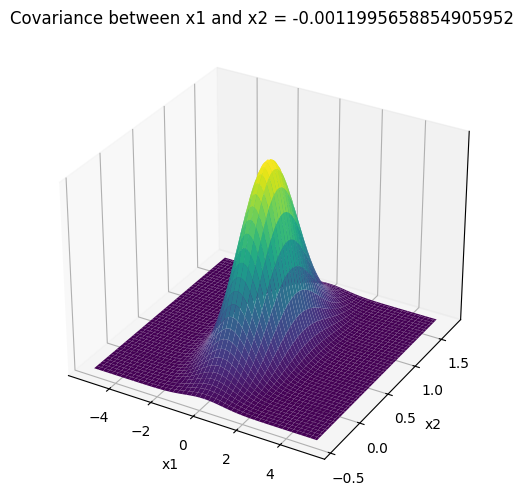

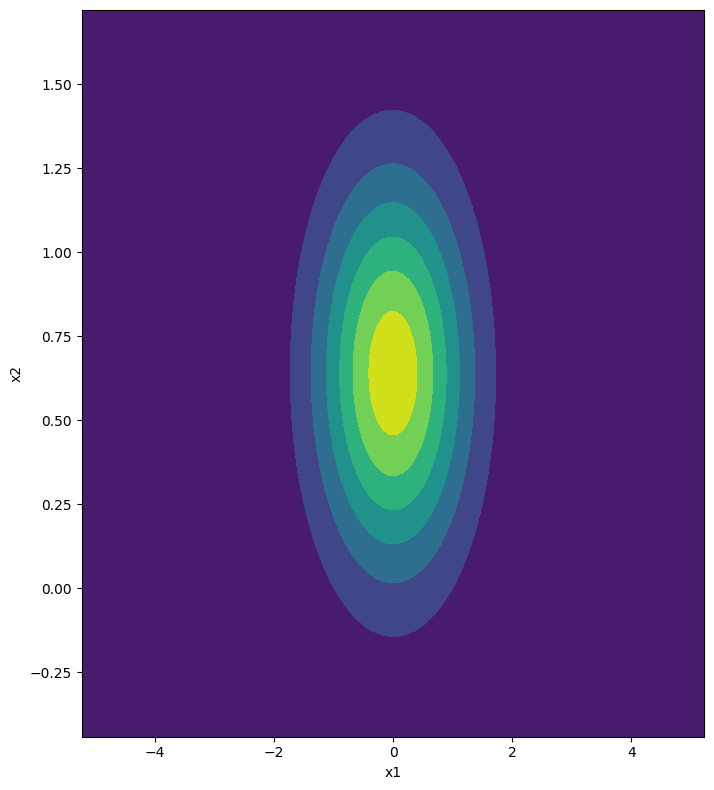

In [8]:
plot(mu_c0,sigma_c0)

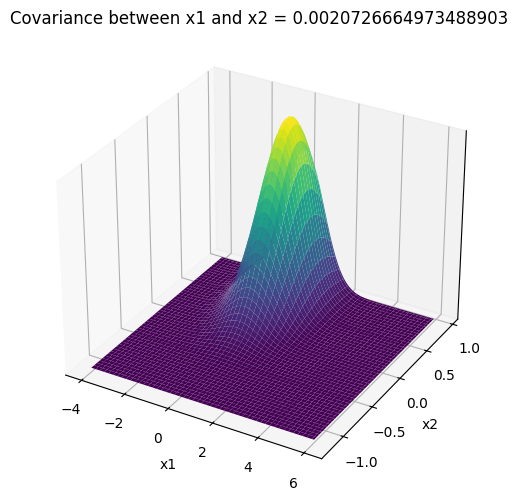

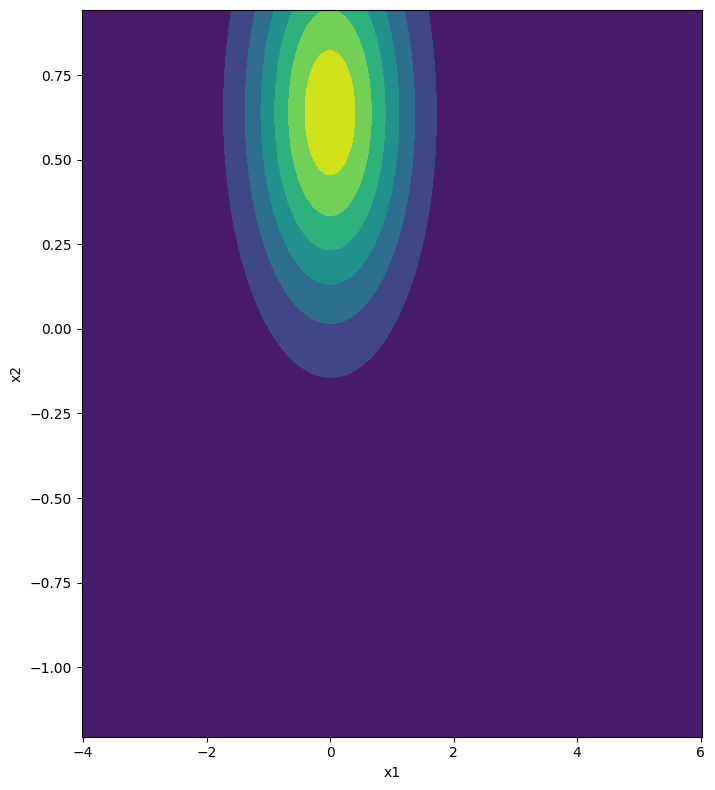

In [9]:
plot(mu_c1,sigma_c1)

In [10]:
class GMM:

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        

        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self.e_step(X)
            self.m_step(X)
            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def e_step(self, X):
        
        self.compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def m_step(self, X):

        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self          

In [25]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 4, delta)
    y = np.arange(-2.0, 4, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid)

    plt.title(title)
    plt.tight_layout()

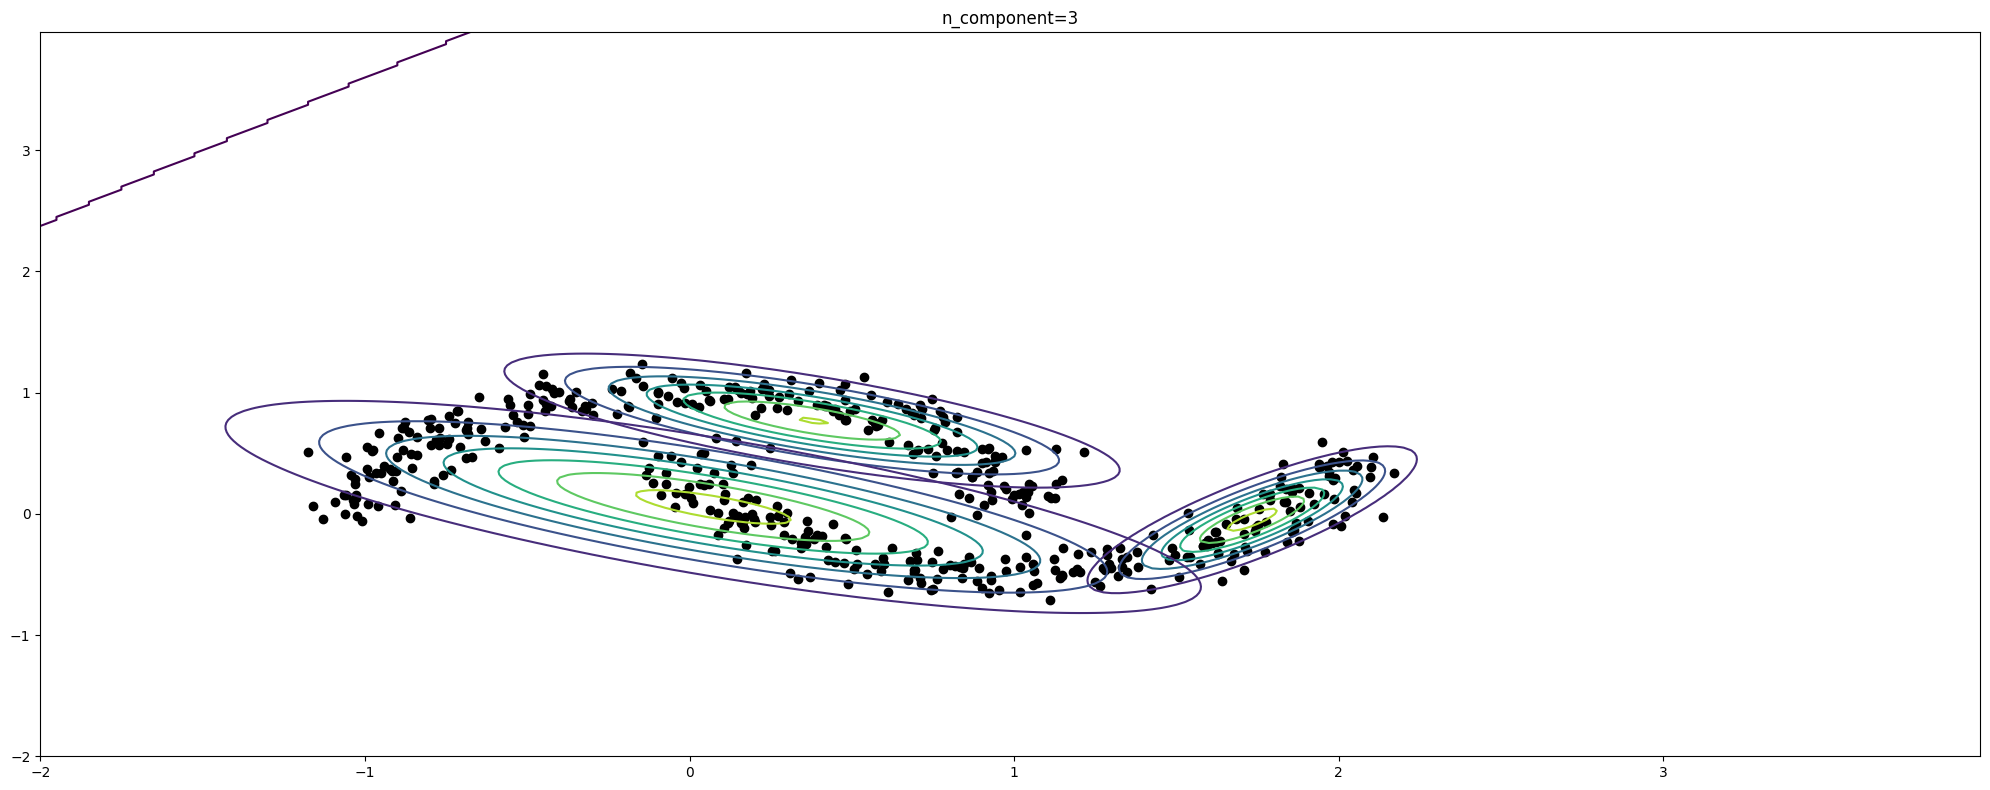

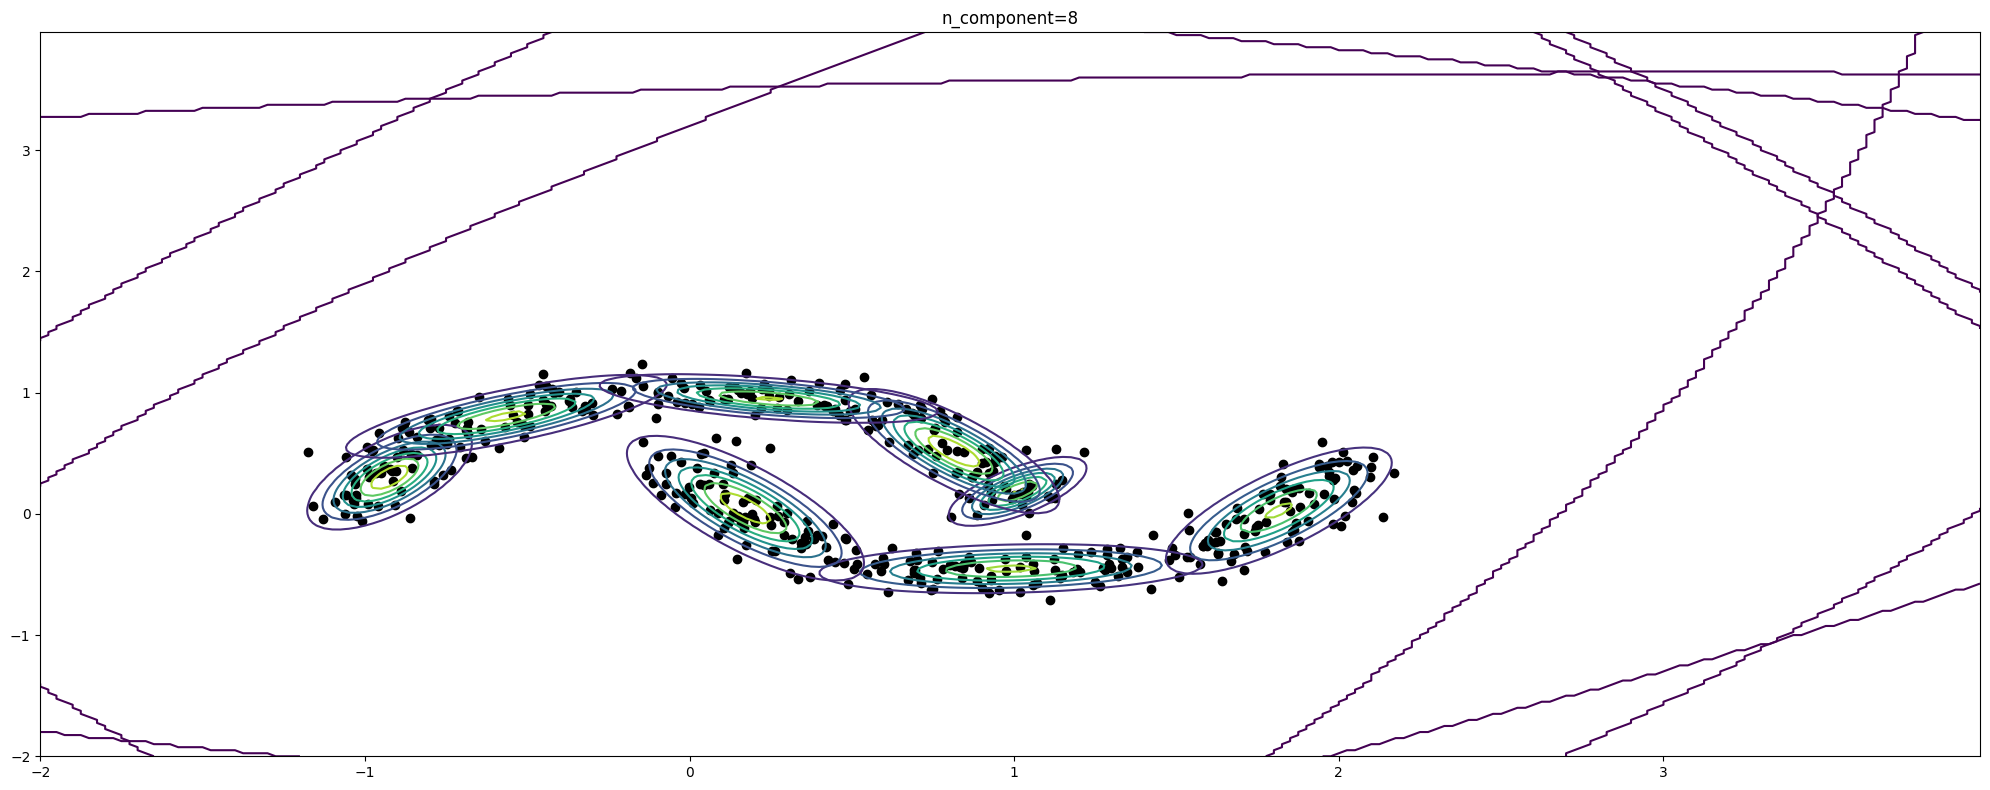

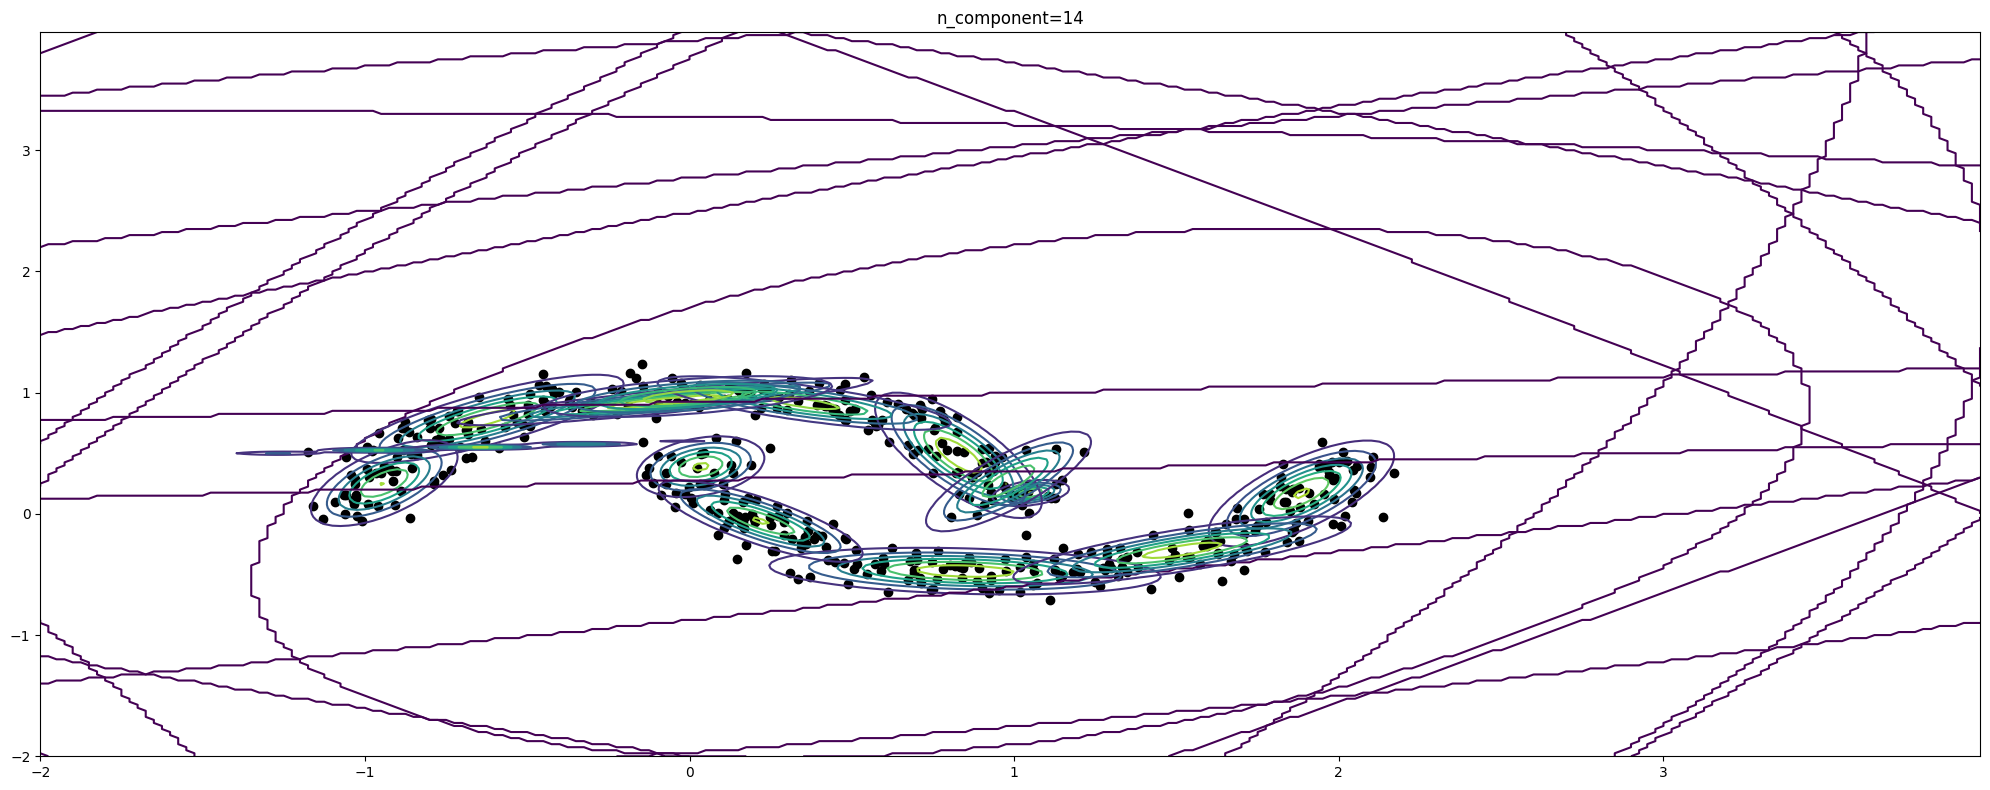

In [26]:
for n_components in range(1,15):
    gmm = GMM(n_components = n_components, n_iters = 50, tol = 1e-4, seed = 4)
    gmm.fit(data)
    if n_components in [3,8,14]:
        plot_contours(data,gmm.means,gmm.covs,f'n_component={n_components}')